In [1]:
# Neural Network Implementation using the MNIST Dataset
# I downloaded the dataset from kaggle but here are the links/ways to access the dataset
# import kagglehub
# 
# # Download latest version
# path = kagglehub.dataset_download("hojjatk/mnist-dataset")
# 
# print("Path to dataset files:", path)
# https://www.kaggle.com/datasets/hojjatk/mnist-dataset?resource=download

In [1]:
# Implemenation of the Neural Network Class: Task 1
import numpy as np
import struct
import os

class NeuralNetwork:
    # Initialize the weights and biases - (Part a Initialization method)
    def __init__(self, input_size=784, hidden_size=10, output_size=10, learning_rate=0.1):
        self.W1 = np.random.randn(hidden_size, input_size) * 0.01
        self.b1 = np.zeros((hidden_size, 1))
        self.W2 = np.random.randn(output_size, hidden_size) * 0.01
        self.b2 = np.zeros((output_size, 1))
        self.learning_rate = learning_rate

    # ReLU activation function  - my own function
    def ReLU(self, Z):
        return np.maximum(0, Z)
    
    # softmax activation function - my own function
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # Prevent overflow
        return expZ / np.sum(expZ, axis=0, keepdims=True)
    
    # Forward Propagation method (Part B)
    def forward_propagation(self, X):
        Z1 = self.W1.dot(X) + self.b1
        A1 = self.ReLU(Z1)
        Z2 = self.W2.dot(A1) + self.b2
        A2 = self.softmax(Z2)
        return Z1, A1, Z2, A2
    
    # Computes the derivative of the ReLU function
    def ReLU_derivative(self, Z):
        return Z > 0
    
    # Converts the labels into one-hot encoding
    def one_hot_encode(self, Y, num_classes=10):
        one_hot_Y = np.zeros((num_classes, Y.size))
        one_hot_Y[Y, np.arange(Y.size)] = 1
        return one_hot_Y
    
    # Computes the  cross-entropy loss - (Part E)
    def compute_cost(self, A2, Y):
        m = Y.size
        one_hot_Y = self.one_hot_encode(Y)
        cost = -np.sum(one_hot_Y * np.log(A2 + 1e-8)) / m
        return cost
    
    # Computes gradients using backpropagation (Part C)
    def backward_propagation(self, X, Y, Z1, A1, Z2, A2):
        m = X.shape[1]
        one_hot_Y = self.one_hot_encode(Y)

        dZ2 = A2 - one_hot_Y
        dW2 = (1 / m) * np.dot(dZ2, A1.T)
        db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

        dZ1 = np.dot(self.W2.T, dZ2) * self.ReLU_derivative(Z1)
        dW1 = (1 / m) * np.dot(dZ1, X.T)
        db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

        return dW1, db1, dW2, db2
    
    
    # Updates the network parameters using gradient descent.
    def update_parameters(self, dW1, db1, dW2, db2):
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
    
    # Trains the neural network using gradient descent. (Part D)
    def train(self, X, Y, iterations=500):
        for i in range(iterations):
            Z1, A1, Z2, A2 = self.forward_propagation(X)
            cost = self.compute_cost(A2, Y)
            dW1, db1, dW2, db2 = self.backward_propagation(X, Y, Z1, A1, Z2, A2)
            self.update_parameters(dW1, db1, dW2, db2)

            if i % 10 == 0:
                predictions = self.predict(X)
                accuracy = self.get_accuracy(predictions, Y)
                print(f"Iteration {i}, Cost: {cost:.4f}, Accuracy: {accuracy:.4f}")
    
    # Makes predictions using the trained model. - Part F
    def predict(self, X):
        _, _, _, A2 = self.forward_propagation(X)
        return np.argmax(A2, axis=0)
    
    # Computes the  accuracy of the predictions.
    def get_accuracy(self, predictions, Y):
        return np.mean(predictions == Y)
    
    # Training the neural network using the mini batch gradient descent
    def train_mini_batch(self, X, Y, batch_size=64, iterations=500):
        m = X.shape[1]  # number of training examples
        for i in range(iterations):
            # shuffling the training set each epoch
            permutation = np.random.permutation(m)
            X_shuffled = X[:, permutation]
            Y_shuffled = Y[permutation]
            
            # splitting into mini batches
            for start_idx in range(0, m, batch_size):
                end_idx = start_idx + batch_size
                X_batch = X_shuffled[:, start_idx:end_idx]
                Y_batch = Y_shuffled[start_idx:end_idx]
    
                # forward propagration 
                Z1, A1, Z2, A2 = self.forward_propagation(X_batch)
                # Computes the cost on the mini-batch 
                cost = self.compute_cost(A2, Y_batch)
                # Backward Propagation
                dW1, db1, dW2, db2 = self.backward_propagation(X_batch, Y_batch, Z1, A1, Z2, A2)
                # Updates Parameters
                self.update_parameters(dW1, db1, dW2, db2)
    
            if i % 10 == 0:
                predictions = self.predict(X)
                accuracy = self.get_accuracy(predictions, Y)
                print(f"Iteration {i}, Cost (mini-batch): {cost:.4f}, Train Accuracy: {accuracy:.4f}")


In [3]:
# I wrote this code so that i could convert images into numpy arrays
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        _, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows * cols)
    return images.T / 255.0  

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        _, num_labels = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels



data_dir = "./"  
train_images_path = os.path.join(data_dir, "train-images.idx3-ubyte")
train_labels_path = os.path.join(data_dir, "train-labels.idx1-ubyte")
test_images_path = os.path.join(data_dir, "t10k-images.idx3-ubyte")
test_labels_path = os.path.join(data_dir, "t10k-labels.idx1-ubyte")

#Loading the dataset:


X_train = load_mnist_images(train_images_path)
Y_train = load_mnist_labels(train_labels_path)
X_test = load_mnist_images(test_images_path)
Y_test = load_mnist_labels(test_labels_path)

print(f"Train shape: {X_train.shape}, Labels shape: {Y_train.shape}")
print(f"Test shape: {X_test.shape}, Labels shape: {Y_test.shape}")


Train shape: (784, 60000), Labels shape: (60000,)
Test shape: (784, 10000), Labels shape: (10000,)


In [4]:
# Training the model:
nn = NeuralNetwork(learning_rate=0.1)
nn.train(X_train, Y_train, iterations=500)


Iteration 0, Cost: 2.3027, Accuracy: 0.0629
Iteration 10, Cost: 2.3018, Accuracy: 0.1124
Iteration 20, Cost: 2.3006, Accuracy: 0.1124
Iteration 30, Cost: 2.2984, Accuracy: 0.1124
Iteration 40, Cost: 2.2941, Accuracy: 0.1124
Iteration 50, Cost: 2.2848, Accuracy: 0.1124
Iteration 60, Cost: 2.2656, Accuracy: 0.1124
Iteration 70, Cost: 2.2290, Accuracy: 0.1235
Iteration 80, Cost: 2.1661, Accuracy: 0.2731
Iteration 90, Cost: 2.0683, Accuracy: 0.3992
Iteration 100, Cost: 1.9229, Accuracy: 0.4763
Iteration 110, Cost: 1.7265, Accuracy: 0.5296
Iteration 120, Cost: 1.5142, Accuracy: 0.5807
Iteration 130, Cost: 1.3318, Accuracy: 0.6235
Iteration 140, Cost: 1.1925, Accuracy: 0.6538
Iteration 150, Cost: 1.0878, Accuracy: 0.6767
Iteration 160, Cost: 1.0071, Accuracy: 0.6974
Iteration 170, Cost: 0.9422, Accuracy: 0.7152
Iteration 180, Cost: 0.8881, Accuracy: 0.7312
Iteration 190, Cost: 0.8417, Accuracy: 0.7455
Iteration 200, Cost: 0.8010, Accuracy: 0.7598
Iteration 210, Cost: 0.7647, Accuracy: 0.7729

In [5]:
# Evalauting the model's performance:
test_predictions = nn.predict(X_test)
test_accuracy = nn.get_accuracy(test_predictions, Y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8856


Prediction: [7], Label: 7


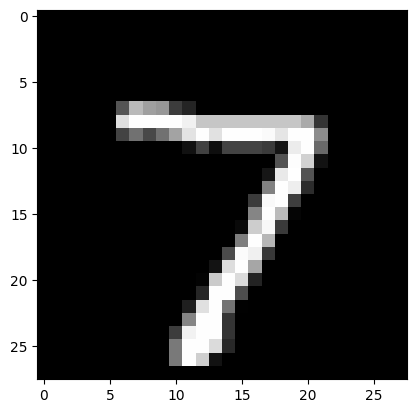

Prediction: [2], Label: 2


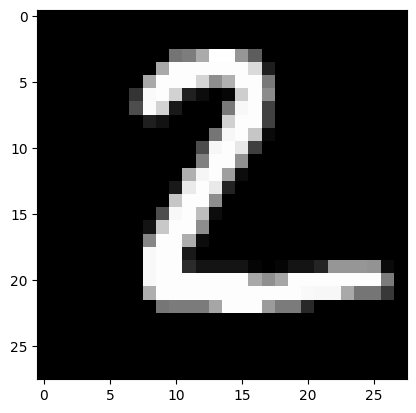

Prediction: [1], Label: 1


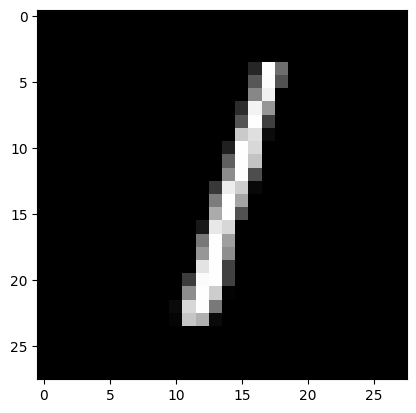

Prediction: [0], Label: 0


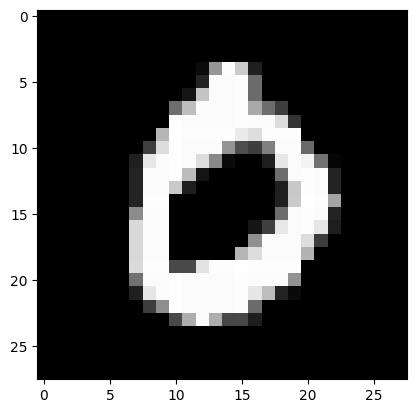

In [6]:
# Testing with sample predictions:
import matplotlib.pyplot as plt

def test_prediction(index, model, X, Y):
    image = X[:, index, None]
    prediction = model.predict(image)
    label = Y[index]

    print(f"Prediction: {prediction}, Label: {label}")
    image = image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(image, interpolation='nearest')
    plt.show()

test_prediction(0, nn, X_test, Y_test)
test_prediction(1, nn, X_test, Y_test)
test_prediction(2, nn, X_test, Y_test)
test_prediction(3, nn, X_test, Y_test)

In [ ]:
#After training the neural network on the MNIST dataset, the model achiveved a training accuracy of 85% and a very similar testing accuracy after 500 iterations.

In [ ]:
# Between mini batch gradient descent and stochastic gradient descent, mini batch gradient descent provides a balance between speed and stability.When compared to batch gradient descent, it can converge more quickly since parameters are updated multiple time per each epoch. Also, when your dataset is large, you don't need all the data in memory for a single gradient descent. Furthermore, the slight variability in updates can help the model escape local minima and usually leads to better generalization.

In [10]:
# Training the mini batch
# Suppose X_train, Y_train are your training data and labels
model = NeuralNetwork(learning_rate=0.1)
model.train_mini_batch(X_train, Y_train, batch_size=64, iterations=50)


Iteration 0, Cost (mini-batch): 0.2677, Train Accuracy: 0.9008
Iteration 10, Cost (mini-batch): 0.0682, Train Accuracy: 0.9381
Iteration 20, Cost (mini-batch): 0.1044, Train Accuracy: 0.9434
Iteration 30, Cost (mini-batch): 0.2549, Train Accuracy: 0.9405
Iteration 40, Cost (mini-batch): 0.0806, Train Accuracy: 0.9499


In [ ]:
# Task 2:
# Task 1 I am choosing pytorch because it has an eager execution model which makes it easier to debug and understand its computational flow.

In [4]:
# Task 2:
# Exploratory Data Analysis
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# checks for gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# converts images to tensor and normalizes to 0,1
transform = transforms.Compose([
    transforms.ToTensor()
])

# Downloads the mnist dataset the pytorch way
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
100.0%
100.0%
100.0%
100.0%


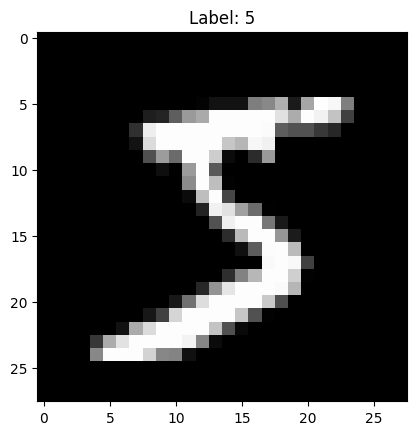

In [5]:
# Visualizing some samples
sample_img, sample_label = train_dataset[0]
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"Label: {sample_label}")
plt.show()


In [6]:
# Train-dev-test split:
from torch.utils.data import random_split, DataLoader

# Let's split the train_dataset into train + dev
train_size = int(0.8 * len(train_dataset))  # 80% for training
dev_size = len(train_dataset) - train_size   # 20% for dev
train_subset, dev_subset = random_split(train_dataset, [train_size, dev_size])

batch_size = 64

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
dev_loader   = DataLoader(dev_subset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
# Implementing forward propagation
class TwoLayerNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, num_classes=10):
        super(TwoLayerNN, self).__init__()
        # Layer 1
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Layer 2
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  
        out = self.fc1(x)          
        out = torch.relu(out)     
        out = self.fc2(out)        
        return out


In [8]:
# Computing the final cost function
criterion = nn.CrossEntropyLoss()


In [9]:
# Implementing gradient descent to train the model
# using the Adam optimizer
model = TwoLayerNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # forward propagation
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward propagation
        optimizer.zero_grad()  
        loss.backward()   
        optimizer.step()     

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dev_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    dev_accuracy = 100 * correct / total
    print(f"Dev Accuracy: {dev_accuracy:.2f}%")

Epoch [1/5], Loss: 0.3842
Dev Accuracy: 94.22%
Epoch [2/5], Loss: 0.1814
Dev Accuracy: 95.47%
Epoch [3/5], Loss: 0.1277
Dev Accuracy: 96.08%
Epoch [4/5], Loss: 0.0969
Dev Accuracy: 96.58%
Epoch [5/5], Loss: 0.0765
Dev Accuracy: 97.01%


In [10]:
# Presenting results using the test set:
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 97.20%


In [ ]:
# Task 3:
# I chose Adam because Adam adapts the learning rate for each parameter, often converging faster than vanilla stochastic gradient descent and it is more tolerant of suboptimal hyperparameters.
# I did not use explicit regularization because MNIST is a simpler dataset. MNIST does not require heavy regularization to achieve high accuracy.